LOADING DATA
Main dataset shape      : (2000, 8)
GI item list shape      : (1500, 9)
PI item list shape      : (1500, 8)

Main dataset columns:
 Job ID                  object
Material Type           object
Area (sq/m)            float64
Thickness (mm)         float64
Material Cost (AED)    float64
Waste Percentage       float64
Waste Cost (AED)       float64
Waste Class             object
dtype: object

  Job ID Material Type  Area (sq/m)  Thickness (mm)  Material Cost (AED)  \
0  JOB_1            PI        18.75           30.00             17996.74   
1  JOB_2            PI        20.65           20.00             13216.70   
2  JOB_3            PI        40.76           25.00             32604.68   
3  JOB_4            GI        19.04            0.86               237.90   
4  JOB_5            PI        47.24           20.00             30235.70   

   Waste Percentage  Waste Cost (AED) Waste Class  
0            0.1873           3370.07        High  
1            0.1273           1

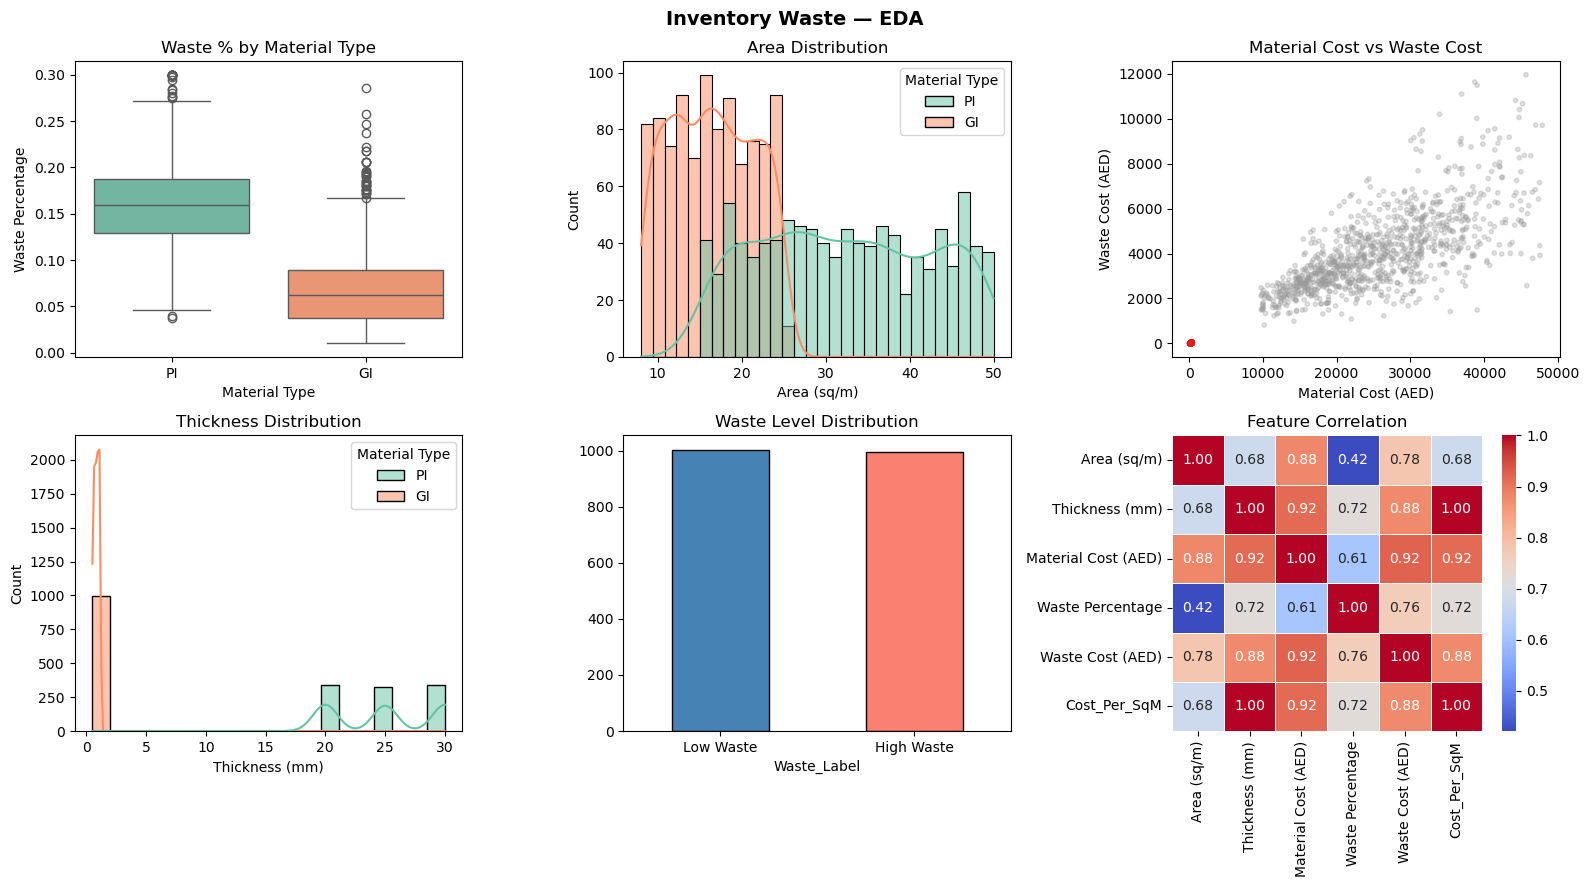


SVM MODEL → Target: Waste Level

Running GridSearchCV (this may take a moment)...
Best Params             : {'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best CV Accuracy        : 0.9437

── Classification Report ──────────────────
              precision    recall  f1-score   support

   Low Waste       0.90      0.99      0.94       201
  High Waste       0.99      0.88      0.93       199

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400

5-Fold CV Accuracy      : 0.9440 ± 0.0155
ROC-AUC Score           : 0.9986


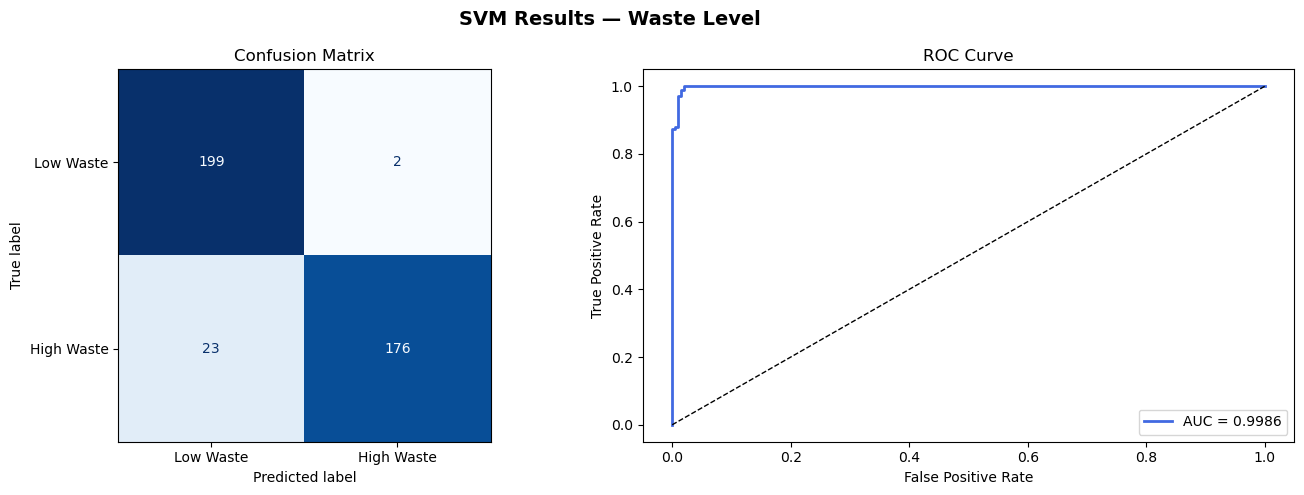


SVM MODEL → Target: Material Type (GI vs PI)

Running GridSearchCV (this may take a moment)...
Best Params             : {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV Accuracy        : 1.0000

── Classification Report ──────────────────
              precision    recall  f1-score   support

          GI       1.00      1.00      1.00       199
          PI       1.00      1.00      1.00       201

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

5-Fold CV Accuracy      : 1.0000 ± 0.0000
ROC-AUC Score           : 1.0000


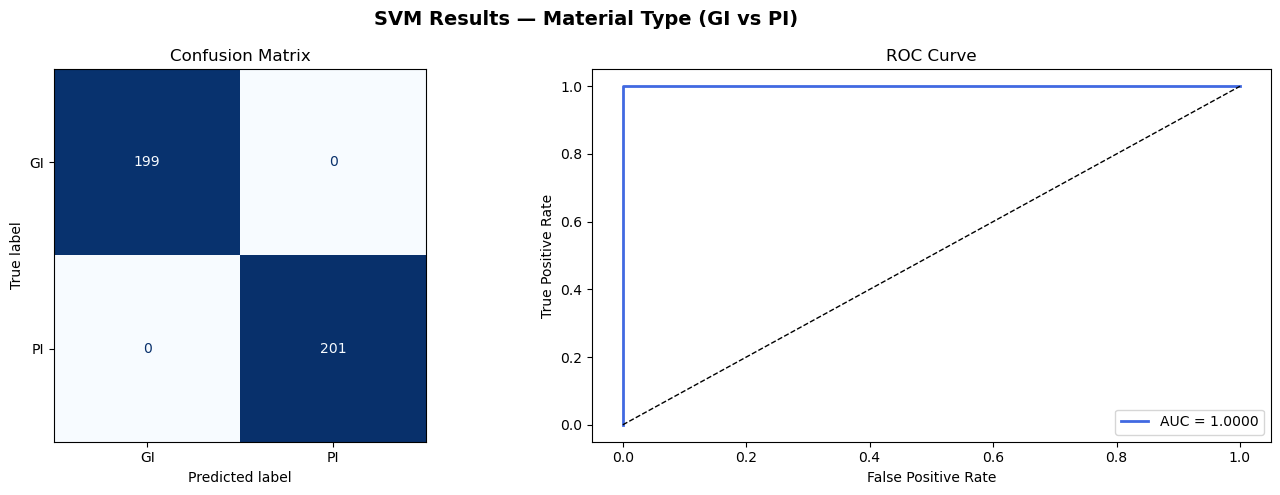


FEATURE IMPORTANCE (Linear SVM Coefficients)

Top features for [Waste Level]:
                Feature  Coefficient  Abs_Coef
     Waste_Cost_Per_SqM     7.755589  7.755589
           Cost_Per_SqM    -2.866492  2.866492
         Thickness (mm)    -1.705545  1.705545
         Thickness_Area     0.271712  0.271712
    Material Cost (AED)    -0.248227  0.248227
      Material_Type_Enc     0.064881  0.064881
Raw_Material_Item_Count    -0.064881  0.064881
          Avg_Item_Cost     0.064881  0.064881
            Area (sq/m)     0.005020  0.005020


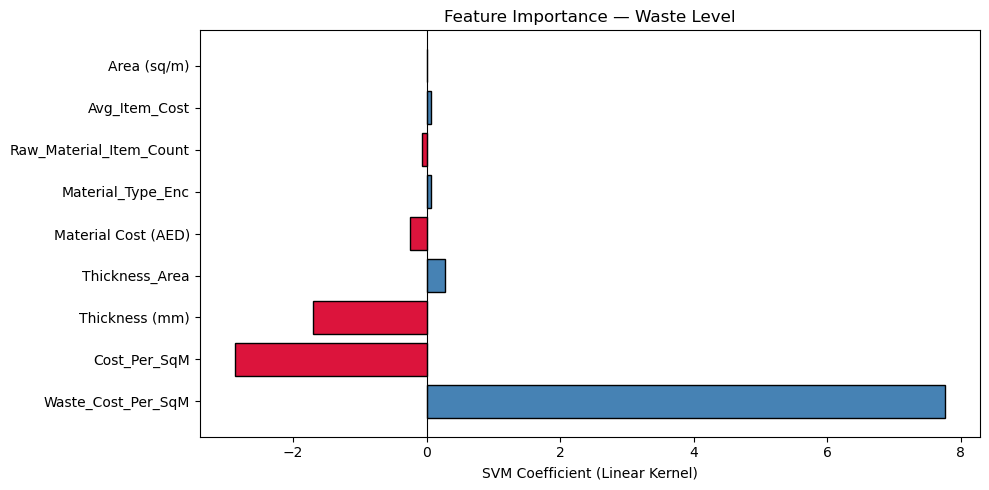


Top features for [Material Type]:
            Feature  Coefficient  Abs_Coef
       Cost_Per_SqM     0.496638  0.496638
     Thickness (mm)     0.488744  0.488744
 Waste_Cost_Per_SqM     0.224814  0.224814
Material Cost (AED)     0.224260  0.224260
     Thickness_Area     0.218266  0.218266
   Waste Cost (AED)     0.106918  0.106918
        Area (sq/m)    -0.009965  0.009965
   Waste Percentage    -0.004600  0.004600


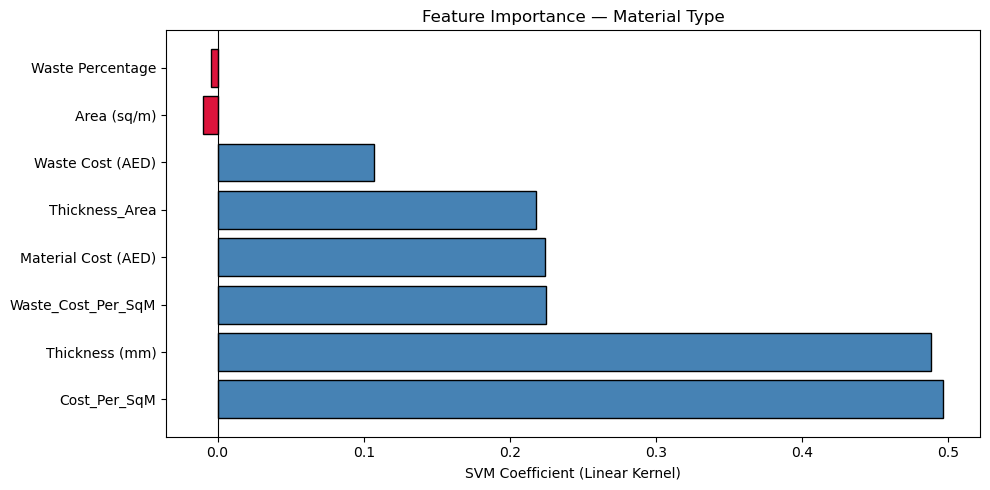


ALL MODELS TRAINED SUCCESSFULLY


In [3]:
"""
SVM Classification Model - Inventory Waste & Production Inefficiency
=====================================================================
Business Problem:
  - Flange material wastage (GI items)
  - PI phenolic sheet wastage
  - Incorrect cutting by labor workers

Datasets:
  - Inventory_Waste_CompanyData.xlsx  - main dataset
  - GI_ITEM_LIST.xlsx                 - GI (Galvanised Iron) item reference
  - PI_ITEM_LIST.xlsx                 - PI (Phenolic Insulation) item reference

Classification Targets:
  1. Waste Level Classification   - Low / High waste per job
  2. Material Type Classification - GI vs PI
"""

# ─────────────────────────────────────────────
# GOOGLE COLAB SETUP
# Upload your 3 Excel files when prompted.
# ─────────────────────────────────────────────

# ─────────────────────────────────────────────
# 1. IMPORTS
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# ─────────────────────────────────────────────
# 2. LOAD DATA
# ─────────────────────────────────────────────
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

df_main = pd.read_csv("data/Inventory_Waste_CompanyData.csv")
df_gi   = pd.read_csv("data/GI_ITEM_LIST.csv")
df_pi   = pd.read_csv("data/PI_ITEM_LIST.csv")

print(f"Main dataset shape      : {df_main.shape}")
print(f"GI item list shape      : {df_gi.shape}")
print(f"PI item list shape      : {df_pi.shape}")
print()
print("Main dataset columns:\n", df_main.dtypes)
print()
print(df_main.head())

# ─────────────────────────────────────────────
# 3. ENRICH WITH ITEM LIST STATISTICS
# ─────────────────────────────────────────────
# Compute summary stats per material type from item lists
gi_avg_unit_cost = df_gi["Unit Cost"].mean()
pi_avg_cost      = df_pi["Purchase Cost"].mean()

gi_raw_count = df_gi[df_gi["Product Category"].str.strip() == "Raw-Material"].shape[0]
pi_raw_count = df_pi[df_pi["Product Category"].str.strip() == "Raw-Material"].shape[0]

gi_consumable_count = df_gi[df_gi["Product Category"].str.strip() == "Consumable"].shape[0]

print(f"\nGI Avg Unit Cost        : {gi_avg_unit_cost:.2f}")
print(f"PI Avg Purchase Cost    : {pi_avg_cost:.2f}")
print(f"GI Raw-Material items   : {gi_raw_count}")
print(f"PI Raw-Material items   : {pi_raw_count}")

# Map enrichment features based on Material Type
df_main["Avg_Item_Cost"] = df_main["Material Type"].map({
    "GI": gi_avg_unit_cost,
    "PI": pi_avg_cost
})

df_main["Raw_Material_Item_Count"] = df_main["Material Type"].map({
    "GI": gi_raw_count,
    "PI": pi_raw_count
})

# ─────────────────────────────────────────────
# 4. FEATURE ENGINEERING
# ─────────────────────────────────────────────
print("\n" + "=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Derived features
df_main["Cost_Per_SqM"]       = df_main["Material Cost (AED)"] / df_main["Area (sq/m)"]
df_main["Waste_Cost_Per_SqM"] = df_main["Waste Cost (AED)"]    / df_main["Area (sq/m)"]
df_main["Thickness_Area"]     = df_main["Thickness (mm)"]       * df_main["Area (sq/m)"]

# ── TARGET 1: Waste Level (Low vs High) ──────
# Threshold: median waste percentage
waste_median = df_main["Waste Percentage"].median()
df_main["Waste_Level"] = (df_main["Waste Percentage"] > waste_median).astype(int)
# 0 = Low Waste, 1 = High Waste
print(f"Waste Percentage median (threshold): {waste_median:.2f}")
print(df_main["Waste_Level"].value_counts().rename({0: "Low Waste", 1: "High Waste"}))

# ── TARGET 2: Material Type ──────────────────
le = LabelEncoder()
df_main["Material_Type_Enc"] = le.fit_transform(df_main["Material Type"])  # GI=0, PI=1
print(f"\nMaterial Type classes   : {dict(zip(le.classes_, le.transform(le.classes_)))}")

# ─────────────────────────────────────────────
# 5. DEFINE FEATURES
# ─────────────────────────────────────────────
FEATURE_COLS = [
    "Area (sq/m)",
    "Thickness (mm)",
    "Material Cost (AED)",
    "Cost_Per_SqM",
    "Waste_Cost_Per_SqM",
    "Thickness_Area",
    "Avg_Item_Cost",
    "Raw_Material_Item_Count",
]

print(f"\nFeatures used           : {FEATURE_COLS}")

# ─────────────────────────────────────────────
# 6. HELPER: TRAIN & EVALUATE SVM
# ─────────────────────────────────────────────
def train_evaluate_svm(X, y, target_name, class_names, tune_hyperparams=True):
    """Full SVM pipeline: split → scale → fit → evaluate → plot."""
    print("\n" + "=" * 60)
    print(f"SVM MODEL → Target: {target_name}")
    print("=" * 60)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ── Pipeline: StandardScaler + SVC ───────
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm",    SVC(probability=True, random_state=42))
    ])

    # ── Optional: Hyperparameter Tuning ──────
    if tune_hyperparams:
        param_grid = {
            "svm__C":      [0.1, 1, 10, 100],
            "svm__gamma":  ["scale", "auto", 0.001, 0.01],
            "svm__kernel": ["rbf", "linear", "poly"],
        }
        print("\nRunning GridSearchCV (this may take a moment)...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline, param_grid,
            cv=cv, scoring="accuracy", n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best Params             : {grid_search.best_params_}")
        print(f"Best CV Accuracy        : {grid_search.best_score_:.4f}")
    else:
        best_model = pipeline
        best_model.fit(X_train, y_train)

    # ── Test Set Evaluation ───────────────────
    y_pred      = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)

    print("\n── Classification Report ──────────────────")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Cross-validation score
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="accuracy")
    print(f"5-Fold CV Accuracy      : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # AUC
    if len(class_names) == 2:
        auc = roc_auc_score(y_test, y_pred_prob[:, 1])
        print(f"ROC-AUC Score           : {auc:.4f}")
    else:
        auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
        print(f"ROC-AUC (OvR)           : {auc:.4f}")

    # ── Plots ─────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"SVM Results — {target_name}", fontsize=14, fontweight="bold")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[0], colorbar=False, cmap="Blues")
    axes[0].set_title("Confusion Matrix")

    # ROC Curve (binary only)
    if len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
        axes[1].plot(fpr, tpr, color="royalblue", lw=2,
                     label=f"AUC = {auc:.4f}")
        axes[1].plot([0, 1], [0, 1], "k--", lw=1)
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title("ROC Curve")
        axes[1].legend(loc="lower right")
    else:
        axes[1].axis("off")
        axes[1].text(0.5, 0.5, f"ROC-AUC (OvR) = {auc:.4f}",
                     ha="center", va="center", fontsize=14)

    plt.tight_layout()
    fname = f"svm_{target_name.replace(' ', '_').lower()}.png"
    plt.show()

    return best_model


# ─────────────────────────────────────────────
# 7. EXPLORATORY DATA ANALYSIS (EDA)
# ─────────────────────────────────────────────
print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle("Inventory Waste — EDA", fontsize=14, fontweight="bold")

# Waste % by Material Type
sns.boxplot(data=df_main, x="Material Type", y="Waste Percentage",
            palette="Set2", ax=axes[0, 0])
axes[0, 0].set_title("Waste % by Material Type")

# Area distribution
sns.histplot(data=df_main, x="Area (sq/m)", hue="Material Type",
             bins=30, kde=True, ax=axes[0, 1], palette="Set2")
axes[0, 1].set_title("Area Distribution")

# Cost vs Waste Cost
axes[0, 2].scatter(df_main["Material Cost (AED)"], df_main["Waste Cost (AED)"],
                   c=df_main["Material_Type_Enc"], cmap="Set1", alpha=0.3, s=10)
axes[0, 2].set_xlabel("Material Cost (AED)")
axes[0, 2].set_ylabel("Waste Cost (AED)")
axes[0, 2].set_title("Material Cost vs Waste Cost")

# Thickness distribution
sns.histplot(data=df_main, x="Thickness (mm)", hue="Material Type",
             bins=20, kde=True, ax=axes[1, 0], palette="Set2")
axes[1, 0].set_title("Thickness Distribution")

# Waste Level counts
df_main["Waste_Label"] = df_main["Waste_Level"].map({0: "Low Waste", 1: "High Waste"})
df_main["Waste_Label"].value_counts().plot(kind="bar", ax=axes[1, 1],
                                            color=["steelblue", "salmon"],
                                            edgecolor="black")
axes[1, 1].set_title("Waste Level Distribution")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

# Correlation heatmap
corr_cols = ["Area (sq/m)", "Thickness (mm)", "Material Cost (AED)",
             "Waste Percentage", "Waste Cost (AED)", "Cost_Per_SqM"]
sns.heatmap(df_main[corr_cols].corr(), annot=True, fmt=".2f",
            cmap="coolwarm", ax=axes[1, 2], linewidths=0.5)
axes[1, 2].set_title("Feature Correlation")

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# 8. MODEL 1 — WASTE LEVEL (Low vs High)
# ─────────────────────────────────────────────
X1 = df_main[FEATURE_COLS + ["Material_Type_Enc"]].values
y1 = df_main["Waste_Level"].values

model_waste = train_evaluate_svm(
    X1, y1,
    target_name="Waste Level",
    class_names=["Low Waste", "High Waste"],
    tune_hyperparams=True
)

# ─────────────────────────────────────────────
# 9. MODEL 2 — MATERIAL TYPE (GI vs PI)
# ─────────────────────────────────────────────
# Features don't include Material_Type_Enc (that's the target)
FEATURE_COLS_MT = [
    "Area (sq/m)",
    "Thickness (mm)",
    "Material Cost (AED)",
    "Waste Percentage",
    "Waste Cost (AED)",
    "Cost_Per_SqM",
    "Waste_Cost_Per_SqM",
    "Thickness_Area",
]

X2 = df_main[FEATURE_COLS_MT].values
y2 = df_main["Material_Type_Enc"].values

model_material = train_evaluate_svm(
    X2, y2,
    target_name="Material Type (GI vs PI)",
    class_names=le.classes_.tolist(),
    tune_hyperparams=True
)

# ─────────────────────────────────────────────
# 10. FEATURE IMPORTANCE (via Linear SVM coefs)
# ─────────────────────────────────────────────
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE (Linear SVM Coefficients)")
print("=" * 60)

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

for (X, feat_names, title) in [
    (X1, FEATURE_COLS + ["Material_Type_Enc"], "Waste Level"),
    (X2, FEATURE_COLS_MT,                     "Material Type"),
]:
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X)
    lin_svm = SVC(kernel="linear", C=1, random_state=42)
    lin_svm.fit(X_sc, y1 if title == "Waste Level" else y2)

    coefs = lin_svm.coef_[0]
    fi_df = pd.DataFrame({"Feature": feat_names, "Coefficient": coefs})
    fi_df["Abs_Coef"] = fi_df["Coefficient"].abs()
    fi_df = fi_df.sort_values("Abs_Coef", ascending=False)

    print(f"\nTop features for [{title}]:")
    print(fi_df.to_string(index=False))

    plt.figure(figsize=(10, 5))
    colors = ["crimson" if c < 0 else "steelblue" for c in fi_df["Coefficient"]]
    plt.barh(fi_df["Feature"], fi_df["Coefficient"], color=colors, edgecolor="black")
    plt.axvline(0, color="black", lw=0.8)
    plt.xlabel("SVM Coefficient (Linear Kernel)")
    plt.title(f"Feature Importance — {title}")
    plt.tight_layout()
    fname = f"feature_importance_{title.replace(' ', '_').lower()}.png"
    plt.show()

print("\n" + "=" * 60)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("=" * 60)